In [2]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.general import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    print("cupy not installed. Using numpy.")

In [3]:
# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = random
# phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
# phaseoffsetfunction = Phase_MinJumps
# harmonicremoval = True
# #Cost Functions available: Pen_DiscreteLinear, Pen_Linear, Pen_Log
# gwscostfunction = Pen_DiscreteLinear
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity
# errormetric = Err_MaxMinDiff



In [97]:
# Initial phase guess 

class kvectorset:
    def __init__(self):
        self.vector_sets = {}
    
    def addharmonicdegree(self, set_number, magnitudes, angles):
        self.vector_sets[set_number] = {
            'magnitudes': magnitudes,
            'angles': angles
        }
    
    def get_maxdegree(self):
        return len(self.vector_sets)
    
    def get_magnitude(self, set_number):
        if set_number in self.vector_sets:
            return self.vector_sets[set_number]['magnitudes']
        else:
            raise ValueError(f"Set number {set_number} does not exist")
    
    def get_angle(self, set_number):
        if set_number in self.vector_sets:
            return self.vector_sets[set_number]['angles']
        else:
            raise ValueError(f"Set number {set_number} does not exist")


def makeinitialkvectors(tweezers):
    """Determine the frequencies of input tweezers."""
    tweezers = tweezers / np.max(tweezers)
    pixel_coordinates = cp.argwhere(tweezers == 1)
    center = cp.array(tweezers.shape) // 2
    vectors = pixel_coordinates - center
    angles = cp.arctan2(vectors[:, 0], vectors[:, 1])
    for i in range(0,len(angles)):
        if vectors[:,1][i] < 0:
            angles[i] += cp.pi
    distances = cp.linalg.norm(vectors, axis=1)
    kmag = distances # / num_points * num_points   ?Why was this here? I don't know...
    
    kvectors = kvectorset()
    kvectors.addharmonicdegree(0,kmag, angles)
    
    return kvectors


def identifyharmonics(kvectors, maxdegree):
    """Indexing starts with 0! Given a list of kvectors, returns a list of all possible harmonics possible in a nested numpy array. So all first order vectors (
    the original kvectors set) will be in the 0th entry of the array, all second order vectors in the 1st entry, and so on until the max degree
    is reached. """

    expanded_kvectors = kvectorset()
    expanded_kvectors = kvectors

    for degree in range(maxdegree):
            if degree not in expanded_kvectors.vector_sets:
                raise ValueError(f"Set number {degree} does not exist")

            current_magnitudes = cp.array(expanded_kvectors.vector_sets[degree]['magnitudes'])
            current_angles = cp.array(expanded_kvectors.vector_sets[degree]['angles'])

            new_magnitudes = []
            new_angles = []

            # Compute pairwise addition and subtraction
            for i in range(len(current_magnitudes)):
                new_magnitudes.append(current_magnitudes + current_magnitudes[i])
                new_magnitudes.append(cp.abs(current_magnitudes - current_magnitudes[i]))

                new_angles.append(current_angles + current_angles[i])
                new_angles.append(cp.abs(current_angles - current_angles[i]))

            new_magnitudes = cp.around(cp.concatenate(new_magnitudes), 3)
            new_angles = cp.concatenate(new_angles)

            # Split the unique pairs back into magnitudes and angles
            unique_magnitudes, unique_indices = cp.unique(new_magnitudes, return_index=True)
            unique_angles = new_angles[unique_indices]

            expanded_kvectors.addharmonicdegree(degree + 1, unique_magnitudes, unique_angles)

    
    return expanded_kvectors
        


## Below are the different offset options
def Off_None(kvectors):
    offsets = kvectors.copy() * 0
    return offsets


def Off_Rand(kvectors):
    return None

def Off_Calc(kvectors):
    return None
# Phase optimizers

def Phase_MinJumps():
    return None

# Tweezer generation

def createtweezers_grid(blankinput, spacing, xnum, ynum):
    """Creates delta function at tweezer locations. blankinput is a blank input array to 
    initialize tweezer in, spacing is the pixel spacing between tweezers, and xnum and ynum are the 
    number of tweezers in the respective directions. Auto-centered and created."""
    simplegrating = cp.zeros(cp.shape(blankinput))
    ysize = cp.shape(blankinput)[0]
    xsize = cp.shape(blankinput)[1]

    for i in range(xsize // 2 + xsize // 10, xsize // 2 + xsize // 10+ spacing*xnum ):
        for j in range(ysize//2 - spacing * ynum // 2 ,ysize // 2 + spacing*ynum // 2):
            pixcoord = 0
            distj1 = j  % spacing
            disti1 = i  % spacing
            distj2 = (spacing - j) % spacing
            disti2 = (spacing - i) % spacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            xrad = 1
            yrad = 1
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating


def derivephase(costfunction, targetintensity, initialphase, iterations, beamtype="Constant", magnification = 1, sigma=1, mu = 1):
    """All inputs are assumed to be of the same dimensionality, 1300 by 1300. Note that magnification adds on to the target, so
    if target is already 3900 by 3900 magnification of 2 will make the simulation space much(!) larger. Beamtypes available are Gaussian or Constant."""
    # Remember, the calculation region is only numpixels by numpixels
    targetintensity = targetintensity / cp.max(targetintensity)
    # Just in case we're using a highly precise target (so not delta function)
    targetmagnification = cp.shape(targetintensity)[0] // numpixels
    targetintensity = expand(targetintensity, magnification)
    magnification = targetmagnification * magnification
    slmphase = set_circlemask(expand(initialphase, magnification), numpixels *magnification)
    inputbeam = set_circlemask(createbeam(beamtype, numpixels * magnification, sigma, mu), numpixels * magnification)
    slmplane = join_phase_ampl(slmphase, inputbeam)
    
    weights=cp.ones((numpixels * magnification, numpixels*magnification))
    weights_previous = targetintensity.copy()
    
    stdinttracker = [] # For use in error calculations
    
    for _ in range(iterations):
        startingpower = cp.sum(cp.abs(slmplane)**2)
        fourierplane = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(slmplane), norm="ortho"))
        fourierintensity = cp.square(cp.abs(fourierplane))
        stdint = cp.divide(fourierintensity, cp.max(fourierintensity))
        stdinttracker.append(stdint)
        weights = costfunction(weights, weights_previous, targetintensity, stdint)
        weights_previous = weights.copy()
        ## This might be a bit confusing, but weights is now the amplitude and we re-combine it with the phase to get the next iteration
        fourierangle = cp.angle(fourierplane)
        fourierplane = join_phase_ampl(fourierangle, weights)
        slmplane = cp.fft.ifftshift(cp.fft.ifft2(cp.fft.ifftshift(fourierplane), norm="ortho"))     
        endingpower = cp.sum(cp.abs(slmplane)**2)
        slmplane = cp.multiply(cp.divide(slmplane, endingpower), startingpower)
        slmplane_numpixels = slmplane.copy()
        slmplane_numpixels = cp.mean(slmplane_numpixels.reshape(numpixels, magnification, numpixels, magnification), axis=(-3,-1))
        
        slmphase = undiscretize_phase(discretize_phase(set_circlemask(cp.angle(slmplane_numpixels), numpixels)))
        readout_slmphase = slmphase.copy()
        slmplane = join_phase_ampl(expand(slmphase, magnification), inputbeam)
        
    
    return readout_slmphase, stdinttracker, stdint

    

## Algorithm subfunctions

def discretize_phase(phase):
    phase=cp.around((phase+cp.pi)*255/(2*cp.pi), decimals=0 )
    return(phase)

def undiscretize_phase(phase):
    phase=phase/255*(2*cp.pi)-cp.pi
    return(phase)

def set_circlemask(inputmatrix, radius):
    image = inputmatrix
    image[cp.sqrt((cp.arange(image.shape[0])[:,None] - image.shape[0]//2)**2 + (cp.arange(image.shape[1]) - image.shape[1]//2)**2) > radius] = 0
  
    return image

def createbeam(beamtype, size, sigma=1, mu = 1):
    blank = cp.zeros((size,size), dtype=complex)
    if beamtype == "Gaussian":
        x, y = cp.meshgrid(cp.linspace(-1,1,size), cp.linspace(-1,1,size))
        d = cp.sqrt(x*x+y*y)
        g = cp.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
        blank = g
    elif beamtype == "Constant":
        blank[:,:] = 1
    ### More support may be added in the future.
    return blank
    

### Cost functions
def weights(w,w_prev,target_im,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)

    w[target_im==1] = cp.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    return (w)

def weights_gaussian(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)

    w[target_im!=0] = cp.sqrt((target_im[target_im!=0] / std_int[target_im!=0])) * w_prev[target_im!=0]
    return (w)

def weightintensity_lukin(target, target_prev, std_int, target_im):
    target[target_im==1] = cp.sqrt((cp.mean(std_int[target_im==1]) / (std_int[target_im==1]+0.001))) * target_prev[target_im==1]
    return target




# Quality of life

def zoomin(array):
    """zooms into the region of interest, threshold is just the average pixel value"""
    threshold = cp.mean(array) * 1.5
    coordinates = cp.argwhere(array > threshold)
    if coordinates.size > 0:
        min_y, min_x = cp.min(coordinates, axis=0)
        max_y, max_x = cp.max(coordinates, axis=0)
    else:
        min_y = min_x = max_y = max_x = None

    zoomedarray = array[min_y-20:max_y+20, min_x-20:max_x+20]
    
    return zoomedarray

def expand(array, multiplier=3):
    """ expands array based on multiplier for use in GWS algorithm or fourier imaging"""
    expanded_array = cp.kron(array, cp.ones((multiplier, multiplier)))
    return expanded_array

def norm(matrix):
    min=cp.min(matrix);max=cp.max(matrix)
    return((matrix-min)/(max-min))

def join_phase_ampl(phase,ampl):
    tmp=cp.zeros((ampl.shape[0],ampl.shape[1]),dtype=complex)
    tmp = cp.multiply(ampl,cp.exp(phase*1j))
    return tmp

# Visualization

# def tweezer


def tweezerintensities(tweezerarray, scale,):
    
    
    return intensityplot
 


In [98]:

testk = makeinitialkvectors(tweezertarget)
kvectors = testk
test= identifyharmonics(kvectors, 1)

In [100]:
testk.get_magnitude(0)

array([133.19534526, 136.12494261, 139.05754205, 141.99295757,
       144.93101807, 147.87156589, 150.81445554, 153.75955255,
       156.70673247, 159.65587994, 162.60688792, 165.55965692,
       168.51409437, 171.47011401, 174.42763543, 177.38658348,
       180.34688797, 183.30848316, 186.27130751, 189.23530326,
       132.57450735, 135.51752654, 138.46299145, 141.41074924,
       144.36065946, 147.31259281, 150.26643005, 153.22206107,
       156.17938404, 159.13830463, 162.09873534, 165.06059493,
       168.02380784, 170.98830369, 173.95401691, 176.92088627,
       179.88885457, 182.8578683 , 185.82787735, 188.79883474,
       132.01893804, 134.97407158, 137.93114224, 140.89002804,
       143.85061696, 146.81280598, 149.77650016, 152.74161188,
       155.70806016, 158.67577005, 161.64467204, 164.61470165,
       167.58579892, 170.55790805, 173.53097706, 176.50495744,
       179.47980388, 182.45547402, 185.43192821, 188.40912929,
       131.52946438, 134.49535308, 137.46272222, 140.43

In [76]:
testk

In [46]:
inputarray = cp.zeros((numpixels,numpixels))
tweezertarget = createtweezers_grid(inputarray, 3, 20,20 )

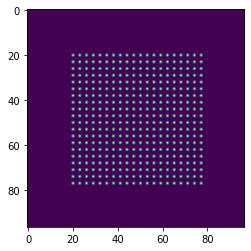

In [47]:
plt.imshow(zoomin(expand(tweezertarget,1)).get())

In [48]:
testphase, teststdlist, teststd = derivephase(weights, tweezertarget, cp.random.rand(numpixels, numpixels),50)

400.0
1
400.0


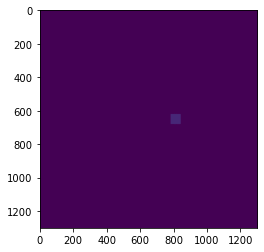

In [49]:
plt.imshow(teststd.get())